In [5]:
# Load dictionary from the pickle file
import pickle
with open('post_samples.pkl', 'rb') as f:
    loaded_samples = pickle.load(f)

In [6]:
import torch
import matplotlib.pyplot as plt

## HMC

dict_keys(['layers.0.bias', 'layers.0.weight', 'layers.1.bias', 'layers.1.weight', 'layers.2.bias', 'layers.2.weight'])


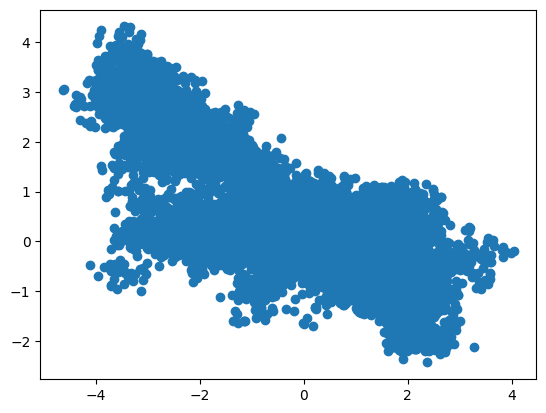

In [7]:
print(loaded_samples.keys())
w1_name, w2_name = 'layers.1.weight', 'layers.1.weight'

# for i in range(10):
#     w1 = loaded_samples[w1_name][:,i,1]
#     w2 = loaded_samples[w2_name][:,i,2]

#     plt.scatter(w1, w2)
#     plt.show()

w1 = loaded_samples[w1_name][:,4,9]
w2 = loaded_samples[w2_name][:,7,9]

plt.scatter(w1, w2)
plt.show()

# plt.hist(w1, bins=15)
# plt.show()
# plt.hist(w2, bins=15)
# plt.show()

## Slang

In [8]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

with open('results_dict.pkl', 'rb') as f:
    results_dict = pickle.load(f)

param_means = results_dict['optimizer']['state']['mean']
prec_factor = results_dict['optimizer']['state']['prec_factor']
prec_diag = results_dict['optimizer']['state']['prec_diag']
cov_matrix = torch.linalg.inv(prec_factor @ prec_factor.t() + prec_diag)
cov_matrix = cov_matrix.detach().cpu().numpy()
cov_matrix[330:350,330:350] = np.zeros((20,20))
plt.figure(figsize=(8, 8)) 
plt.imshow((cov_matrix), cmap='PuBuGn', interpolation='nearest') 
plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results_dict.pkl'